In [51]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

In [52]:
#Import data
df = pd.read_csv('../Data/Sentiment CSV/MergedSenti.csv')

In [53]:
#Check the classes
df.Class.value_counts(normalize = True)

Exercise            0.281677
SuicidalThoughts    0.268076
Depression          0.264165
Happy               0.186083
Name: Class, dtype: float64

In [54]:
#Check the head 
df.head()

,neg,neu,pos,compound,Post,Class
0,0.163,0.658,0.178,0.1406,attempted yesterday i had an exit yesterday an...,SuicidalThoughts
1,0.000,0.892,0.108,0.4404,my bf of years just tried to hang himself las...,SuicidalThoughts
2,0.141,0.665,0.194,0.8683,he gave up because of me we have shared many ...,SuicidalThoughts
3,0.045,0.873,0.081,0.2960,running out of options does anyone have any co...,SuicidalThoughts
4,0.299,0.588,0.113,-0.9927,my life is shit i feel like shit i hate mysel...,SuicidalThoughts


In [55]:
#Selecting the classes i'm interested 
depresed = df[df['Class'] == 'Depression'][:7000].reset_index(drop = True)
happy = df[df['Class'] == 'Happy'][:3500].reset_index(drop = True)
exercise = df[df['Class'] == 'Exercise'][:3500].reset_index(drop = True)

In [56]:
#Create a new dataframe 
df = pd.concat([depresed, happy, exercise]).reset_index(drop = True)

In [57]:
#Hot Encode the classes
df.Class = df.Class.apply(lambda x: 1 if x == 'Depression' else 0)

In [58]:
#Reset the index of dataframe
df = df.reset_index(drop = True)

In [59]:
#Select  X and y
X = df['Post'].to_list()
y = df['Class'].to_list()

In [60]:
#Split in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
#Download the pretrained bert model. Links got it from tensorflow hub website for text classification, bert
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [32]:
#Create the Funtional API model

#Bert Layers
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(input_text)
outputs = bert_encoder(preprocessed_text)

#Neural Layers
l1 = tf.keras.layers.Dense(128, name="Dense1")(outputs['pooled_output'])
l2 = tf.keras.layers.Dropout(0.5, name = 'dropout1')(l1)
l3 = tf.keras.layers.Dense(64, name = 'Dense2')(l2)
l4 = tf.keras.layers.Dropout(0.5, name = 'dropout2')(l3)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l4)

#Output layer
bert_depr_model = tf.keras.Model(inputs=[input_text], outputs = [out_layer])

#Check the model summary
bert_depr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [33]:
#Compile the model
bert_depr_model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [34]:
#Fit the model
history = bert_depr_model.fit(X_train, y_train,
                             batch_size = 64,
                             validation_data = (X_test, y_test),
                             epochs = 2)

Epoch 1/2
147/147 [==============================] - 7456s 51s/step - loss: 0.2754 - accuracy: 0.8957 - val_loss: 0.0738 - val_accuracy: 0.9762
Epoch 2/2
147/147 [==============================] - 7530s 51s/step - loss: 0.1623 - accuracy: 0.9443 - val_loss: 0.0666 - val_accuracy: 0.9751


In [35]:
#Save the model
bert_depr_model.save('./Saved Models/bert_depression_model')

INFO:tensorflow:Assets written to: ./Saved Models/bert_depression_model\assets


INFO:tensorflow:Assets written to: ./Saved Models/bert_depression_model\assets


In [4]:
#Load the model
model = tf.keras.models.load_model('./Saved Models/bert_depression_model/')

In [35]:
#dataset for validation only with depression post
val_text = pd.read_csv('../Data/ValidationText.csv')

In [49]:
#Testing some exercise text

text = "yeahhhh i wil go to the gym after 6 months pause"
prob = model.predict([text])
print('*' + text + '*')
print('----------------------------------------------')
print(f'The risk probability of this text is: {prob[0][0]}')

*yeahhhh i wil go to the gym after 6 months pause*
----------------------------------------------
The risk probability of this text is: 0.3134517967700958


In [41]:
#Testing the model how good will catch the risky posts
prob = model.predict([val_text['Text'][3]])
print(val_text['Text'][3])
print('-------------------------------------------------')
print(f'The risk probability of this text is: {prob[0][0]}')

Depression is not something to be happy about. I hate the fact that everything I just said, is only a quarter of what I feel. Some people get excited when they're diagnosed with depression. 'Oh I'm going to tell my friends, maybe I'll get some sympathy .' No you stupid c***. It is the worst thing, that's why, when I was diagnosed with depression. I felt crazy. Because I'm not normal. I'm depressed, and pain lives in me, and I can't escape it. That's the sad thing. No one takes it seriously.
-------------------------------------------------
The risk probability of this text is: 1.0


In [65]:
prob = model.predict([val_text['Text'][3]])
print(val_text['Text'][15])
print('-------------------------------------------------')
print(f'The risk probability of this text is: {prob[0][0]}')

I blame myself for everything bad that happens.
-------------------------------------------------
The risk probability of this text is: 1.0


In [61]:
#Create predictions from model
prediction = model.predict(X_test)
prediction

array([[9.9995518e-01],
       [9.9999917e-01],
       [4.0882826e-04],
       ...,
       [1.7619890e-01],
       [9.2565924e-02],
       [9.9998248e-01]], dtype=float32)

In [64]:
#The output will be a probability from 0 to 1 (sigmoid function) so i will encode those 0 and 1 with a simple check as below
prediction = [1 if x >= 0.5 else 0 for x in prediction]

In [ ]:
#Evaluate the model
#model.evaluate(X_test, y_test)

#### Model Performance on metrics

In [67]:
#Accuracy Score
print(f'Accuracy: {np.round(accuracy_score(y_test, prediction),3)}')

Accuracy: 0.975


In [68]:
#Recall score which i'm more interested
print(f'Recall Score: {np.round(recall_score(y_test, prediction),3)}')

Recall Score: 0.956


In [69]:
#Checking how the confusion matrix looks like
conf_matrix = confusion_matrix(y_test, prediction)
conf_matrix

array([[2266,   11],
       [ 104, 2239]], dtype=int64)

In [70]:
#Getting those vales from confsion matrix
tn, fp, fn, tp = conf_matrix.ravel()

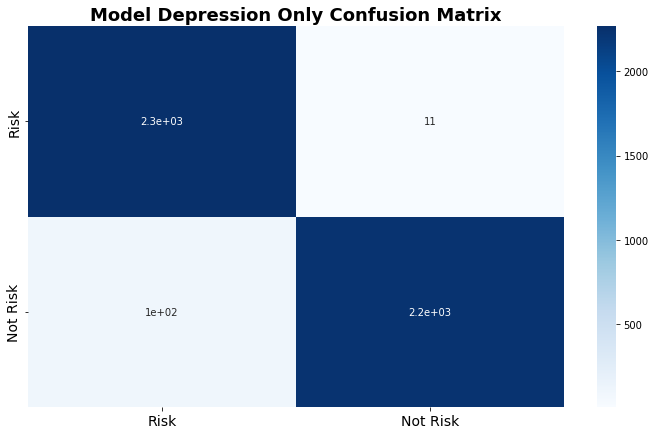

In [80]:
#Plot the confusion matrix with a heatmap
plt.figure(figsize=(12,7))
plt.title('Model Depression Only Confusion Matrix', weight = 'bold', fontsize = 18)
fig = sns.heatmap(conf_matrix, cmap = 'Blues', annot = True)
fig.xaxis.set_ticklabels(['Risk', 'Not Risk'], fontsize = 14)
fig.yaxis.set_ticklabels(['Risk', 'Not Risk'], fontsize = 14)
plt.savefig('../Images/depression_conf_matrix');

In [72]:
#Create a funtion to return te risky level based on probability of post
def risk_assessment_prediction(text):
    prob = model.predict([text])
    prob = prob[0][0]
    if prob >= 0.5 and prob < 0.75:
        return f'This Post should be considered Risky (Probability is: {prob})'
    elif prob >= 0.75 and prob < 0.9:
        return f'This Post should be considered High Risky (Probability is: {prob})'
    elif prob >= 0.9:
        return f'Alert!. This Post has a high level of Risk (Probability is: {prob})'
    elif prob < 0.2:
        return  f'This Post should has no signs of Risk (Probability is: {prob})'
    elif prob >= 0.2 and prob < 0.5:
        return f'This Post should not be considered as Risky (Probability is: {prob})'

#### Checking the function and model

In [ ]:
risk_assessment_prediction('I feel good')

In [74]:
risk_assessment_prediction("ohh god i feel so bad, i can't live like this")

'Alert!. This Post has a high level of Risk (Probability is: 0.9999972581863403)'